**This notebook works in full path:** `/uscms/home/jennetd/nobackup/hbb-prod-modes/vh-dec-2021`

Binding in singularity:  `-B /uscms/home/jennetd/nobackup/:/jennet_dir`

In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle
import pandas as pd

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

from others.plotter import *

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('others/xsec.json') as f:
    xs = json.load(f)

with open('others/pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','ZH','WH']


#To calculate significance
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

#### CUSTOMIZED PARAMETERS
year = str(2017)
working_dir = '/jennet_dir/hbb-prod-modes/vh-dec-2021/'

In [30]:
!cp /jennet_dir/hbb-prod-modes/vh-dec-2021/make-hists-1mv.py .

In [29]:
!ls /jennet_dir/hbb-prod-modes/vh-dec-2021/

2016		  make-hists-1mv-charm.py   outfiles
2017		  make-hists-1mv-charm.py~  outfiles-beforeXmas
2018		  make-hists-1mv-light.py   plot-vh.ipynb
README.md	  make-hists-1mv-light.py~  pmap.json
README.md~	  make-hists-1mv.py	    pmap_mc.json
boostedhiggs	  make-hists-1mv.py~	    shell
dask-report.html  make-hists-3mv-charm.py   submit-dask.py
draw_datafit.C	  make-hists-3mv-light.py   triggers.json
draw_datafit.C~   make-hists-3mv.py	    vh-scripts
infiles		  make-pkl.py		    xsec.json
jupyter.sh	  muon_triggers.json


In [2]:
indir = working_dir + "outfiles/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)

started = 0
for filename in infiles:
    
    if "data" in filename:
        continue
    if "bsm" in filename:
        continue

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)
        scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in out['sumw'].items()}
        out['templates'].scale(scale_lumi, 'dataset')
        tmp = out['templates'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('genflavor1', overflow = 'all').integrate('genflavor2', overflow='all').integrate('region','signal')

        if started == 0:
            templates = tmp
            started += 1
        else:
            templates.add(tmp)
    
        del out

Loading /jennet_dir/hbb-prod-modes/vh-dec-2021/outfiles/2017_dask_higgs.coffea
Loading /jennet_dir/hbb-prod-modes/vh-dec-2021/outfiles/2017_dask_qcd.coffea
Loading /jennet_dir/hbb-prod-modes/vh-dec-2021/outfiles/2017_dask_top.coffea
Loading /jennet_dir/hbb-prod-modes/vh-dec-2021/outfiles/2017_dask_wandvv.coffea
Loading /jennet_dir/hbb-prod-modes/vh-dec-2021/outfiles/2017_dask_z.coffea


## Plot 2D distribution for different signal processes

In [70]:
!ls /jennet_dir/hbb-prod-modes

CMSSW_10_2_13  from-dylan    scale-factors     vbf-ul-feb-2022	 xsecs_1
adelina        july-2021     ul-infiles        vh-dec-2021
code-2021      october-2021  vbf-ddb-jan-2022  vh-ul-march-2022
ewkv-2022      pfnano	     vbf-tnp-jan-2022  xsecs


In [60]:
def plot_2d_score(signal_p, templates):
    
    h = templates.sum('msd1', 'msd2').integrate('process', signal_p, overflow = 'all')

    fig, ax = plt.subplots(2,2,sharex='col',sharey='row')
    plt.suptitle(signal_p)

    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)

#     ax[-1,0].set_yscale('log')
#     ax[0,0].set_xscale('log')

    xprojection = hist.export1d(h.integrate('ddc2')).numpy()
    yprojection = hist.export1d(h.integrate('ddb1')).numpy()
    
#     print(yprojection[0])

    ybins = yprojection[1]
    xbins = xprojection[1]
    
    print(xbins)
    print(ybins)

    ax[1,1].hist(ybins[:-1],
                 weights=yprojection[0],
                 bins=ybins,
                 histtype='step',
                 orientation='horizontal')

    ax[0,0].hist(xbins[:-1],
                 weights=xprojection[0],
                 bins=xbins,
                 histtype='step')
    
    ax[1,1].set_xlabel('Events')
    ax[0,0].set_ylabel('Events')

    #Remove overlapping ticks 
    yticks_0 = ax[0,0].yaxis.get_major_ticks()
    yticks_0[0].set_visible(False)

    xticks_1 = ax[1,1].xaxis.get_major_ticks()
    xticks_1[0].set_visible(False)

    yticks_01 = ax[0,1].yaxis.get_major_ticks()
    yticks_01[-1].set_visible(False)


    X, Y = np.meshgrid(xbins[:-1],ybins[:-1])
    w = h.values()[()]
    
    #print(w)

    ax[1,0].hist2d(X.flatten(),Y.flatten(),weights=w.flatten(),bins=(xbins, ybins))
    ax[1,0].set_xlabel('Jet 1 DDB Score')
    ax[1,0].set_ylabel('Jet 2 DDCvL')

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]
[0.   0.01 0.02 0.05 0.1  0.2  0.5  1.  ]


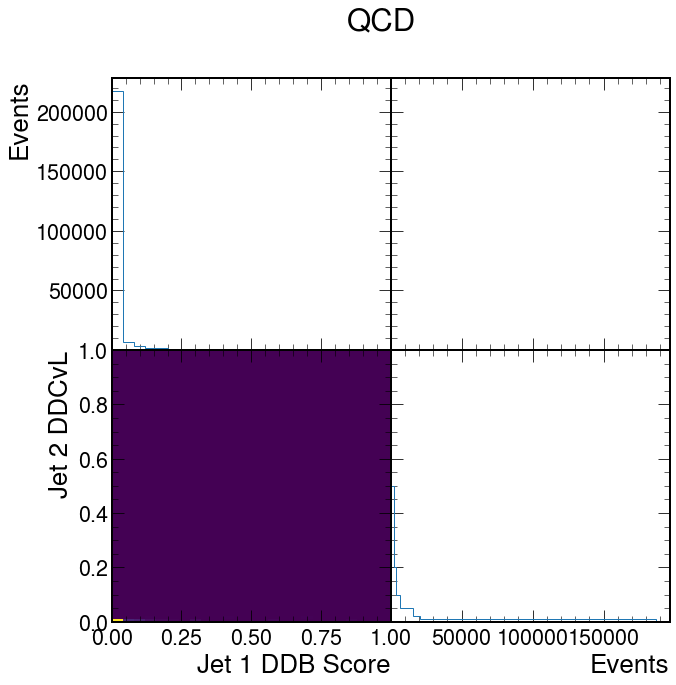

In [61]:
plot_2d_score("QCD", templates)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]
[0.   0.01 0.02 0.05 0.1  0.2  0.5  1.  ]


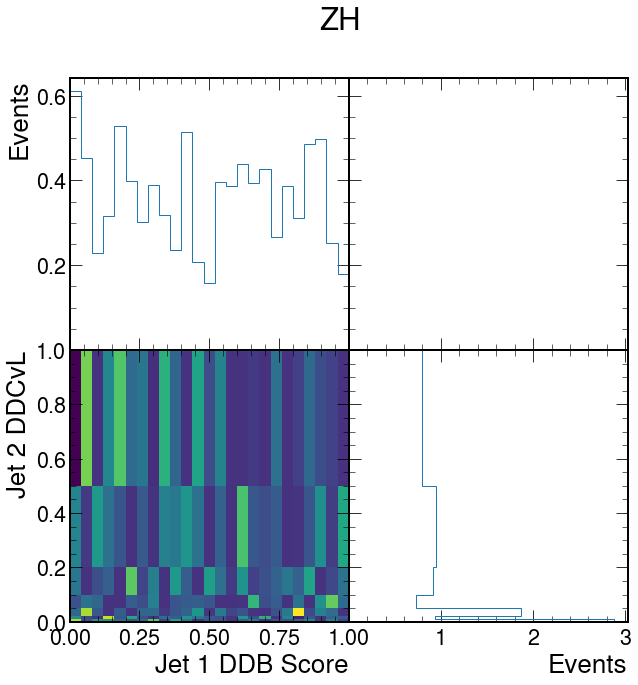

In [62]:
plot_2d_score("ZH", templates)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]
[0.   0.01 0.02 0.05 0.1  0.2  0.5  1.  ]


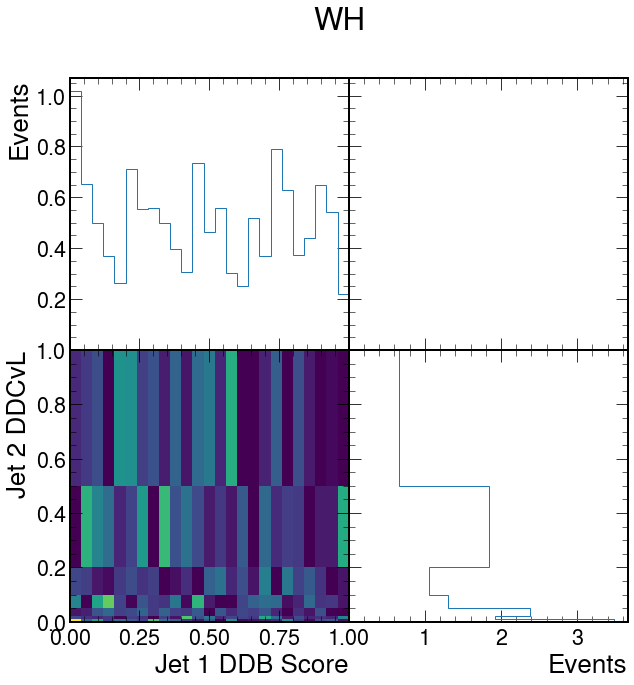

In [65]:
plot_2d_score("WH", templates)

<AxesSubplot:xlabel='Jet 1 ddb score', ylabel='Events'>

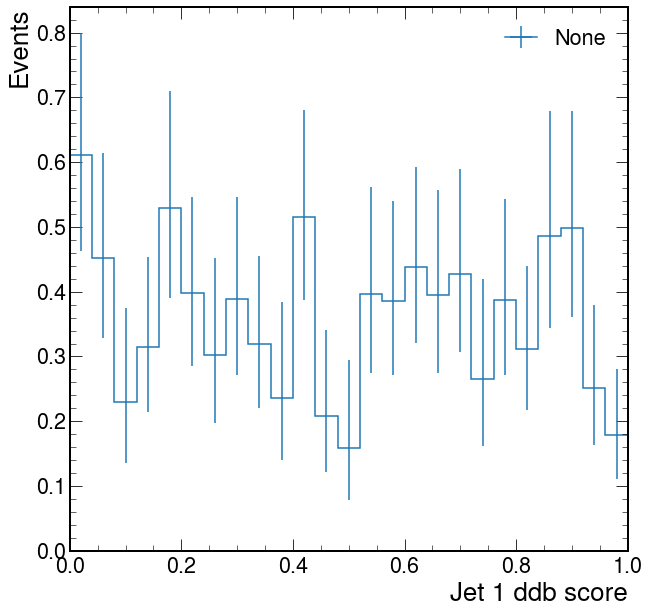

In [68]:
hist.plot1d(templates.sum('msd1','msd2','ddc2').integrate('process','ZH'))